# Cross-slope section

This notebook gives an example on how to obtain a section through gridded data. We use the __[function](https://unidata.github.io/MetPy/latest/examples/cross_section.html#sphx-glr-examples-cross-section-py)__ `metpy.interpolate.cross_section` to do so. 
In this example we plot the along-slope velocity component across the Antarctic continental shelf break. In order to calculate the along-slope velocity component, we will need to calculate the topographic gradient first, which we do with the help of the `xgcm` __[module](https://xgcm.readthedocs.io/en/latest/)__. 

Load modules

In [1]:
# Standard modules
from pathlib import Path
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr

import xgcm
import cf_xarray

# Load metpy module to obtain cross section 
# (Select the conda/analysis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj

By default retain metadata after operations. This can retain out of date metadata, so some caution is required

In [2]:
xr.set_options(keep_attrs=True);

Start a cluster with multiple cores

In [3]:
client = Client() 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36953/status,
Dashboard: /proxy/36953/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45507,Workers: 7
Dashboard: /proxy/36953/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:35279,Total threads: 4
Dashboard: /proxy/43365/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41253,


In [4]:
def centre_longitude(ds, centre=0, lonvar=None):
    """Wrap longitude to specified centre"""
   
    if lonvar is None:
        # Use cf_xarray to find longitude coordinate
        lonvar = ds.cf.coordinates['longitude'][0]

    upper_limit = centre + 180.

    # Ensure coordinates are within range 0 -> 360
    ds.coords[lonvar] = ds.coords[lonvar] % 360.
    
    # Wrap all longitude locations above upper limit and re-sort by longitude
    ds.coords[lonvar] = xr.where(ds.coords[lonvar] > upper_limit, 
                                 ds.coords[lonvar] - 360., 
                                 ds.coords[lonvar])
    ds = ds.sortby(ds[lonvar])
    
    return ds

### Load Data

Nominate a database from which to load the data and define an experiment

In [5]:
session = cc.database.create_session()
experiment = '01deg_jra55v13_ryf9091'

Limit to Southern Ocean and single RYF year

In [6]:
lat_slice  = slice(-80, -59)

start_time = '2086-01-01'
end_time   = '2086-12-31'

Load bathymetry data. Discard the geolon and geolat coordinates: these are 2D curvilinear coordinates that are only required when working above 65N

In [7]:
hu = cc.querying.getvar(experiment, 'hu', session, n=1).drop(['geolat_c', 'geolon_c']).sel(yu_ocean=lat_slice).load()

Load velocity data, limit to upper 500m and take the mean in time

In [8]:
u = cc.querying.getvar(experiment, 'u', session, ncfile="ocean.nc",
                       start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(st_ocean=slice(0, 500)).mean('time')

v = cc.querying.getvar(experiment, 'v', session, ncfile="ocean.nc",
                       start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(st_ocean=slice(0, 500)).mean('time')

Load model grid information directly from a grid data file

In [9]:
path_to_folder = Path('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/')
grid = xr.open_mfdataset(path_to_folder / 'ocean_grid.nc', combine='by_coords').drop(['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c'])

### Along-slope velocity

We calculate the along-slope velocity component by projecting the velocity field to the tangent vector, $u_{along} = \boldsymbol{u \cdot \hat{t}}$, and the cross-slope component by projecting to the normal vector, $v_{cross} = \boldsymbol{u \cdot \hat{n}}$. The schematic below defines the unit normal normal and tangent vectors for a given bathymetric contour, $\boldsymbol{n}$ and $\boldsymbol{t}$ respectively. 

![Sketch of topographic gradient](images/topographic_gradient_sketch.png)

Accordingly, the code below calculates the along-slope velocity component as

$$ u_{along} = (u,v) \boldsymbol{\cdot} \left(\frac{h_y}{|\nabla h|} , -\frac{h_x}{|\nabla h|}\right) = 
u \frac{h_y}{|\nabla h|} - v \frac{h_x}{|\nabla h|}, $$  

and similarly the cross-slope velocity component as

$$ v_{cross} = (u,v) \boldsymbol{\cdot} \left(\frac{h_x}{|\nabla h|} , \frac{h_y}{|\nabla h|}\right)  = 
u \frac{h_x}{|\nabla h|} + v \frac{h_y}{|\nabla h|}.$$ 


We need the derivatives of the bathymetry which we compute using the `xgcm` functionality.

In [10]:
# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')

# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

Calculate along-slope velocity component

In [11]:
# Along-slope velocity
u_along = u * dhu_dy / topographic_slope_magnitude - v * dhu_dx / topographic_slope_magnitude

# Load the data
u_along = u_along.load()

# Similarly, we can calculate the cross-slope velocity:
#v_cross = u*dhu_dx/topographic_slope_magnitude + v*dhu_dy/topographic_slope_magnitude

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  retu

Vertical averaging (we only need this to plot the velocity on a map)

In [12]:
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(experiment, 'st_edges_ocean', session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': u.yu_ocean, 'xu_ocean': u.xu_ocean}, axis=[1, 2])

In [13]:
# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(experiment, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.sel(st_ocean=slice(0, 500))

# Depth average gives us the barotropic velocity
u_barotropic = (u_along * thickness).sum('st_ocean') / thickness.sum('st_ocean')
#v_barotropic = (v_cross * thickness).sum('st_ocean') / thickness.sum('st_ocean')

### Interpolate gridded data to section

This is where we make use of the `cross-section` function from the MetPy package. It is designed for xarray, but requires the data to look in a certain way, hence we need to change the coordinate names and parse the data. 

In [14]:
# Create dataset
ds = xr.Dataset({"u_along": u, "lat": u.yu_ocean, "lon": u.xu_ocean, "hu": hu})

# Rename coordinate names
ds = ds.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})

# Centre on zero longitude as this is what metpy requires
ds = centre_longitude(ds)

# MetPy parsing
u_parsed = ds.metpy.parse_cf('u_along', coordinates={'y': 'y', 'x': 'x'})

In [15]:
# Define number of points you want to interpolate
step_no = 50

# Start and end point coordinates of section (in approximate cross-slope orientation)
shelf_coord = (-66.5, -269.3)
deep_coord  = (-64, -271.9)

# Finally, interpolate gridded data onto the section
u_section = cross_section(u_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps=step_no, interp_type='linear')
u_section

<xarray.DataArray 'u_along' (st_ocean: 39, index: 50)>
dask.array<dask_aware_interpnd, shape=(39, 50), dtype=float32, chunksize=(7, 50), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 4.332 ... 383.0 423.7 468.4
    metpy_crs  object Projection: latitude_longitude
    x          (index) float64 90.7 90.64 90.58 90.53 ... 88.25 88.2 88.15 88.1
    y          (index) float64 -66.5 -66.45 -66.4 -66.35 ... -64.1 -64.05 -64.0
  * index      (index) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Attributes: (12/13)
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    ...             ...
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf90...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration under th...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...

Use `pyproj` to project transect coordinates into a cartesian south polar projection (see [this blog post](https://climate-cms.org/posts/2021-10-01-pyproj.html) for more information)

In [16]:
source_crs = pyproj.CRS(init="epsg:4326") # Global lat-lon coordinate system
target_crs = pyproj.CRS(init="epsg:3031") # Cartesian south polar projection

latlon_to_polar = pyproj.Transformer.from_crs(source_crs, target_crs)

x_m, y_m = latlon_to_polar.transform(u_section.x, u_section.y)

Calculate the euclidian distance between each point, add a leading zero for the origin and convert from metres to kilometres

In [17]:
dist = np.sqrt((x_m[1:] - x_m[:-1])**2 + (y_m[1:] - y_m[:-1])**2)
dist = [0, *np.cumsum(dist) / 1000.]

Add along-transect distance coordinate in km

In [18]:
u_section = u_section.assign_coords(distance=('index', dist))

### Plotting

Create a circular path to clip plots

In [19]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

Create a land mask for plotting, set land cells to 1 and rest to NaN

In [21]:
land = xr.where(np.isnan(hu.rename('land')), 1, np.nan)

Set default fontsize

In [22]:
ft_size = 16
plt.rcParams.update({'font.size': ft_size})

#### Map of topographic slope and location of cross-slope section

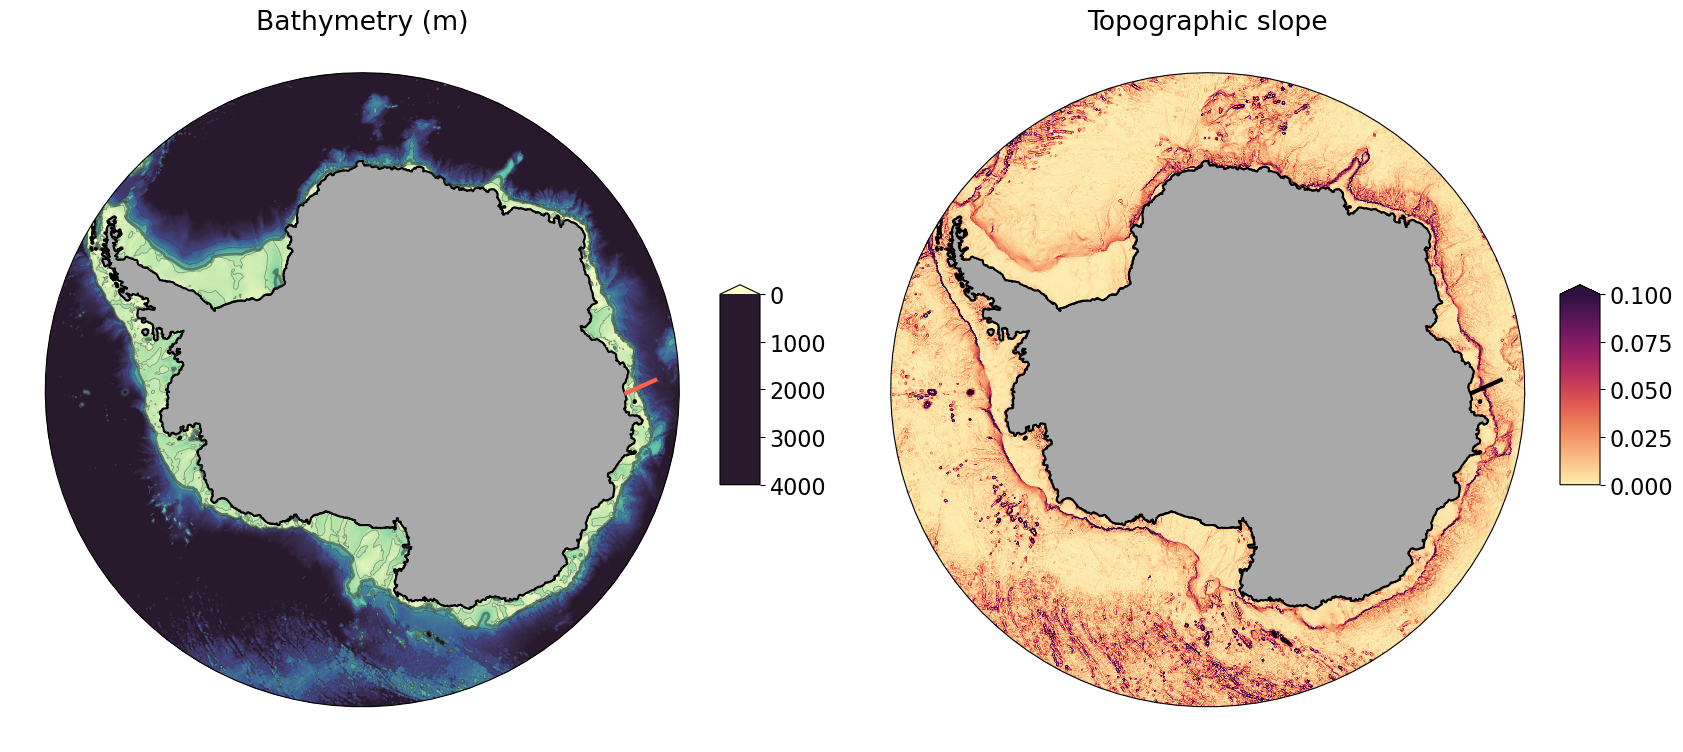

In [23]:
fig = plt.figure(1, figsize=(20, 10))

# create suplot axes
# the `facecolor` kwarg is used to denotes the color that should be used to fill when no data
# is available (in this case, for anything south of 80S)
ax0 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo(), facecolor="darkgrey")
ax1 = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo(), facecolor="darkgrey")

# Set background the same for both plots
for ax in [ax0, ax1]:
    ax.set_boundary(circle, transform=ax.transAxes)
    # Land
    land.plot.contourf(ax=ax, colors='darkgrey', zorder=2,
                       transform=ccrs.PlateCarree(), add_colorbar=False)
    # Coastline
    land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1],
                                transform=ccrs.PlateCarree(), add_colorbar=False)


# LEFT PANEL: bathymetry

# Depth contours
hu.plot.contour(ax=ax0, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Bathymetry
sc = hu.plot(ax=ax0, add_colorbar=False, cmap=cm.cm.deep, 
             transform=ccrs.PlateCarree(), vmin=0, vmax=4000)

# Customise colorbar
cbar_ax = fig.add_axes([0.48, 0.4, 0.02, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', shrink=0.5, extend='min')
cbar.ax.invert_yaxis()
# Hack work-around for bug in matplotlib when inverting the axis, the bottom extend triangle has the under-value color
cbar.ax._children[2].set_color(cm.cm.deep.get_over())

# Location of cross-slope section (East Antarctica)
ax0.plot([shelf_coord[1], deep_coord[1]], [shelf_coord[0], deep_coord[0]],
         color='tomato', linewidth=3, transform=ccrs.PlateCarree())


# RIGHT PANEL: topographic slope

# Topographic slope 
sc = topographic_slope_magnitude.plot(ax=ax1, cmap=cm.cm.matter, transform=ccrs.PlateCarree(),
                                      vmin=0, vmax=0.1, add_colorbar=False)

# Customise colorbar
cbar_ax = fig.add_axes([0.9, 0.4, 0.02, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', shrink=0.5, extend='max')

# Location of cross-slope section (East Antarctica)
ax1.plot([shelf_coord[1], deep_coord[1]], [shelf_coord[0], deep_coord[0]],
         color='k', linewidth=3, transform=ccrs.PlateCarree())


# Add titles to the subplots
ax0.set_title('Bathymetry (m)')
ax1.set_title('Topographic slope');

#### Map of along-slope velocity with bathymetry contours

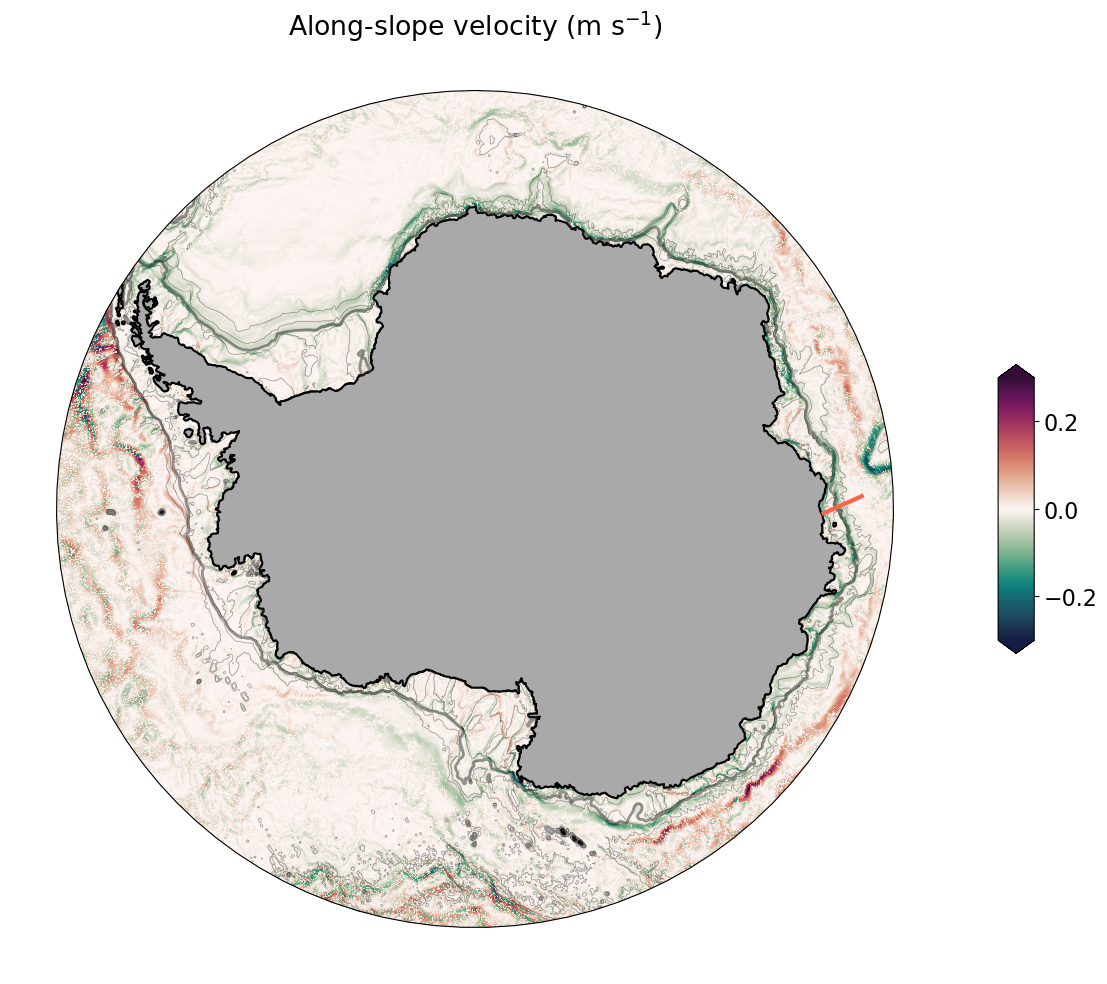

In [24]:
fig = plt.figure(1, figsize=(15, 15))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(), facecolor="darkgrey")
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax, colors='darkgrey', zorder=2,
                   transform=ccrs.PlateCarree(), add_colorbar=False)

# Coastline
land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1],
                            transform=ccrs.PlateCarree(), add_colorbar=False)

# Depth contours
hu.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = u_barotropic.plot(ax = ax, cmap=cm.cm.curl,
                       transform=ccrs.PlateCarree(), vmin=-0.3, vmax=0.3,
                       cbar_kwargs={'orientation': 'vertical',
                                    'shrink': 0.25,
                                    'extend': 'both',
                                    'label': None,
                                    'aspect': 8})

# Location of cross-slope section (East Antarctica)
ax.plot([shelf_coord[1], deep_coord[1]], [shelf_coord[0], deep_coord[0]],
        color='tomato', linewidth=3, transform=ccrs.PlateCarree())
    
ax.set_title('Along-slope velocity (m s$^{-1}$)');

#### Cross-slope section of along-slope velocity

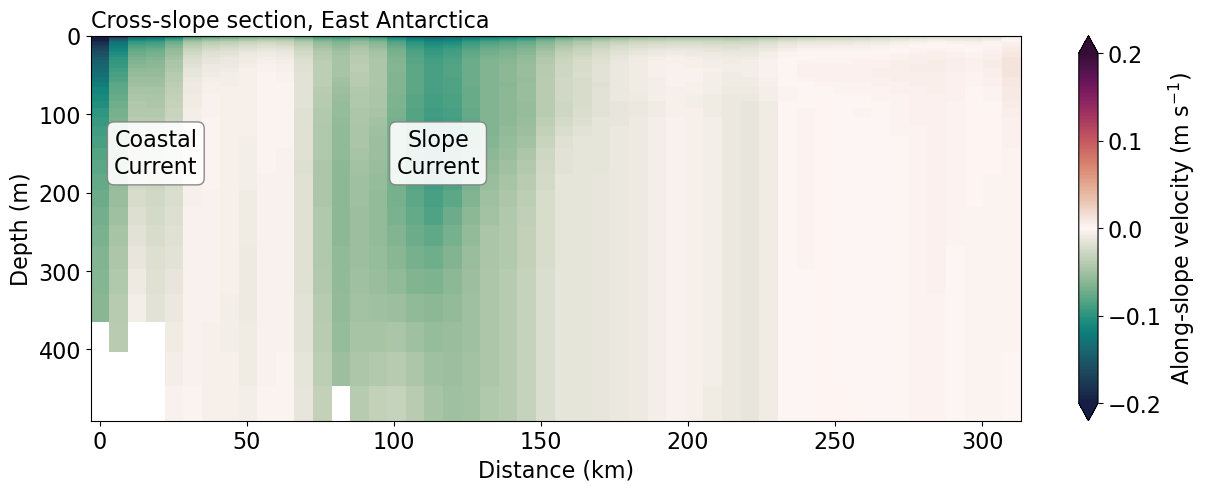

In [25]:
u_section.plot.pcolormesh(x='distance', y='st_ocean',
                          cmap=cm.cm.curl, vmin=-0.2, vmax=0.2, 
                          cbar_kwargs={'extend':'both',
                                       'label':'Along-slope velocity (m s$^{-1}$)'},
                          yincrease=False, add_labels=False, figsize=(15, 5))

plt.title('Cross-slope section, East Antarctica', fontsize=ft_size, loc='left')
plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')

# Add annotations
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
plt.text(115, 150, "Slope\nCurrent", ha="center", va="center", bbox=bbox_props)
plt.text(19, 150, "Coastal\nCurrent", ha="center", va="center", bbox=bbox_props);